In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from contextlib import contextmanager
from pathlib import Path
import functools

from tqdm import tqdm
from einops import rearrange, reduce
import plotly.express as px
import plotly.graph_objects as go
import torch
from torch.func import functional_call, vmap, grad
from cupbearer import detectors, tasks, utils, scripts
from torch import Tensor, nn

In [3]:
# Written by Nora Belrose
@contextmanager
def atp(model: nn.Module, noise_acts: dict[str, Tensor], *, head_dim: int = 0):
    """Perform attribution patching on `model` with `noise_acts`.

    This function adds forward and backward hooks to submodules of `model`
    so that when you run a forward pass, the relevant activations are cached
    in a dictionary, and when you run a backward pass, the gradients w.r.t.
    activations are used to compute approximate causal effects.

    Args:
        model (nn.Module): The model to patch.
        noise_acts (dict[str, Tensor]): A dictionary mapping (suffixes of) module
            paths to noise activations.
        head_dim (int): The size of each attention head, if applicable. When nonzero,
            the effects are returned with a head dimension.

    Example:
    ```python
    noise = {
        "model.encoder.layer.0.attention.self": torch.randn(1, 12, 64, 64),
    }
    with atp(model, noise) as effects:
        probs = model(input_ids).logits.softmax(-1)
        probs[0].backward()

    # Use the effects
    ```
    """
    # Keep track of all the hooks we're adding to the model
    handles: list[nn.modules.module.RemovableHandle] = []

    # Keep track of activations from the forward pass
    mod_to_clean: dict[nn.Module, Tensor] = {}
    mod_to_noise: dict[nn.Module, Tensor] = {}

    # Dictionary of effects
    effects: dict[str, Tensor] = {}
    mod_to_name: dict[nn.Module, str] = {}

    # Backward hook
    def bwd_hook(module: nn.Module, _, grad_output: tuple[Tensor, ...] | Tensor):
        # Unpack the gradient output if it's a tuple
        if isinstance(grad_output, tuple):
            grad_output, *_ = grad_output

        # Use pop() to ensure we don't use the same activation multiple times
        # and to save memory
        clean = mod_to_clean.pop(module)
        direction = mod_to_noise[module] - clean

        # Group heads together if applicable
        if head_dim > 0:
            direction = direction.unflatten(-1, (-1, head_dim))
            grad_output = grad_output.unflatten(-1, (-1, head_dim))

        # Batched dot product
        effect = torch.linalg.vecdot(direction, grad_output)

        # Save the effect
        name = mod_to_name[module]
        effects[name] = effect

    # Forward hook
    def fwd_hook(module: nn.Module, _, output: tuple[Tensor, ...] | Tensor):
        # Unpack the output if it's a tuple
        if isinstance(output, tuple):
            output, *_ = output

        mod_to_clean[module] = output.detach()

    for name, module in model.named_modules():
        # Hooks need to be able to look up the name of a module
        mod_to_name[module] = name

        # Check if the module is in the paths
        for path, noise in noise_acts.items():
            if not name.endswith(path):
                continue

            # Add a hook to the module
            handles.append(module.register_full_backward_hook(bwd_hook))
            handles.append(module.register_forward_hook(fwd_hook))

            # Save the noise activation
            mod_to_noise[module] = noise

    try:
        yield effects
    finally:
        # Remove all hooks
        for handle in handles:
            handle.remove()

        # Clear grads on the model just to be safe
        model.zero_grad()

In [4]:
task = tasks.tiny_natural_mechanisms("hex", device="mps")

Loaded pretrained model attn-only-1l into HookedTransformer
Moving model to device:  mps


In [5]:
with open(".cupbearer_cache/tiny_natural_mechanisms/hex_task.json") as f:
    task_config = json.load(f)

# cpu to avoid MPS issues with tensors that are too large
effect_tokens = torch.tensor(
    task_config["effect_tokens"], dtype=torch.long, device="cpu"
)

In [6]:
for name, _ in task.model.named_modules():
    print(name)


embed
hook_embed
pos_embed
hook_pos_embed
blocks
blocks.0
blocks.0.ln1
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.attn
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_post
ln_final
ln_final.hook_scale
ln_final.hook_normalized
unembed


# Defining the detector

In [7]:
class AttributionDetector(detectors.AnomalyDetector):
    def __init__(self, shapes: dict[str, tuple[int, ...]], output_func):
        super().__init__()
        self.shapes = shapes
        self.output_func = output_func

    def train(
        self,
        trusted_data: torch.utils.data.Dataset,
        untrusted_data: torch.utils.data.Dataset | None,
        save_path: Path | str | None,
        batch_size: int = 64,
        **kwargs,
    ):
        assert trusted_data is not None

        # Why shape[-2]? We are going to sum over the last dimension during attribution
        # patching. We'll then use the second-to-last dimension as our main dimension
        # to fit Gaussians to (all earlier dimensions will be summed out first).
        # This is kind of arbitrary and we're putting the onus on the user to make
        # sure this makes sense.
        self._means = {
            name: torch.zeros(shape[-2], device="mps")
            for name, shape in self.shapes.items()
        }
        self._Cs = {
            name: torch.zeros(shape[-2], shape[-2], device="mps")
            for name, shape in self.shapes.items()
        }
        self._n = 0

        dataloader = torch.utils.data.DataLoader(trusted_data, batch_size=batch_size)
        for batch in tqdm(dataloader):
            inputs = utils.inputs_from_batch(batch).to("mps")
            noise = {
                name: torch.randn((batch_size, *shape), device="mps")
                for name, shape in self.shapes.items()
            }
            with atp(task.model, noise) as effects:
                out = self.model(inputs)
                out = self.output_func(out)
                assert out.shape == (batch_size,), out.shape
                out.backward(torch.ones_like(out))

            self._n += batch_size

            for name, effect in effects.items():
                effect = reduce(
                    effect, "batch ... h -> batch h", "sum", batch=batch_size
                )
                self._means[name], self._Cs[name], _ = (
                    detectors.statistical.helpers.update_covariance(
                        self._means[name], self._Cs[name], self._n, effect
                    )
                )

        self.means = self._means
        self.covariances = {k: C / (self._n - 1) for k, C in self._Cs.items()}
        if any(torch.count_nonzero(C) == 0 for C in self.covariances.values()):
            raise RuntimeError("All zero covariance matrix detected.")

        self.inv_covariances = {
            k: detectors.statistical.mahalanobis_detector._pinv(C, rcond=1e-5)
            for k, C in self.covariances.items()
        }

    def layerwise_scores(self, batch):
        inputs = utils.inputs_from_batch(batch).to("mps")
        batch_size = len(inputs)
        noise = {
            name: torch.randn((batch_size, *shape), device="mps")
            for name, shape in self.shapes.items()
        }
        # AnomalyDetector.eval() wraps everything in a no_grad block, need to undo that.
        with torch.enable_grad():
            with atp(task.model, noise) as effects:
                out = self.model(inputs)
                out = self.output_func(out)
                assert out.shape == (batch_size,), out.shape
                out.backward(torch.ones_like(out))
                # self.sample_grad_func(inputs)

        for name, effect in effects.items():
            effects[name] = reduce(
                effect, "batch ... h -> batch h", "sum", batch=batch_size
            )

        distances = detectors.statistical.helpers.mahalanobis(
            effects,
            self.means,
            self.inv_covariances,
        )

        return distances

    def _get_trained_variables(self, saving: bool = False):
        return {
            "means": self.means,
            "inv_covariances": self.inv_covariances,
        }

    def _set_trained_variables(self, variables):
        self.means = variables["means"]
        self.inv_covariances = variables["inv_covariances"]

In [8]:
def effect_prob_func(logits):
    assert logits.ndim == 3
    probs = logits.softmax(-1)
    # Sum over vocab (but not batch) dim:
    return probs[:, -1, effect_tokens].sum(-1)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:40<00:00,  6.29it/s]


Evaluating:   0%|          | 0/32 [00:00<?, ?it/s]

2024-04-30 23:10:12.978 | INFO     | cupbearer.detectors.anomaly_detector:eval:151 - AUC_ROC (all): 0.5212
2024-04-30 23:10:12.979 | INFO     | cupbearer.detectors.anomaly_detector:eval:152 - AP (all): 0.5273


(defaultdict(dict,
             {'all': {'AUC_ROC': 0.521174430847168,
               'AP': 0.5272542639027851}}),
 {'all': <Figure size 640x480 with 1 Axes>})

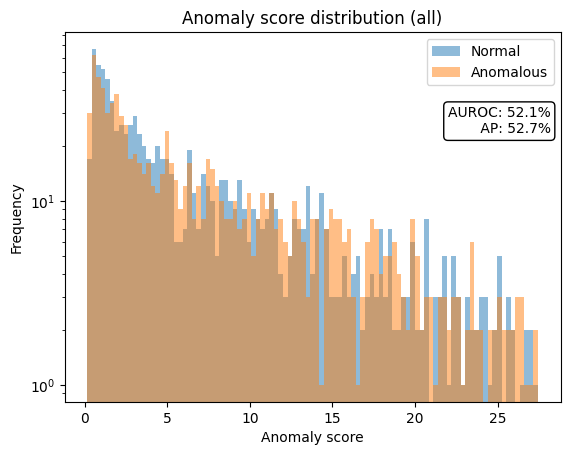

In [9]:
detector = AttributionDetector(
    shapes={"blocks.0.attn.hook_z": (16, 8, 64)}, output_func=effect_prob_func
)
scripts.train_detector(task, detector, save_path=None, eval_batch_size=64)

In [10]:
px.imshow(detector.covariances["blocks.0.attn.hook_z"].cpu())